I'm going to try my best to make this functional.

In [2]:
# !pip install --upgrade pip setuptools==57.5.0
# !pip install regressors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 36.4 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
arviz 0.15.1 requires setuptools>=60.0.0, but you have setuptools 57.5.0 which is incompatible.
cvxpy 1.3.2 requires setuptools>65.5.1, but you have setuptools 57.5.0 which is incompatible.


  Preparing metadata (setup.py) ... done
  Created wheel for regressors: filename=regressors-0.0.3-py2.py3-none-any.whl size=12399 sha256=4983be387b59156dae6794ac2d50c9d71557ed97f9482c1ce5acdcc6a2594369
  Stored in directory: /root/.cache/pip/wheels/85/e8/ec/b8fe5e2d41af2f4760b0d8ce1ae8f01c78df5d1b0883dee2fe
Successfully built regressors


# Imports and Housekeeping

In [4]:
# Basic Packages
import pandas as pd
import numpy as np
from functools import reduce
from datetime import datetime as dt

# Visualizations
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Modeling
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from regressors import stats
import statsmodels.api as sm

# Connecting to drive to bring in data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
pd.options.display.float_format = '{:,.2f}'.format
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (12,8)
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)

<ipython-input-5-0ae081f986c8>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Get Data

This is from a python API. All of the API work and data manipulation was done in PyCharm and can be found on Github

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NFL Model/Data/Model Data/final_data.csv", index_col=0)

In [ ]:
df.columns

Index(['game_id', 'season', 'week', 'home_team', 'away_team', 'home_score',
       'score_diff', 'score_total', 'away_score', 'home_team_win',
       'ewma_dynamic_window_rushing_offense_home',
       'ewma_dynamic_window_passing_offense_home',
       'ewma_dynamic_window_rushing_defense_home',
       'ewma_dynamic_window_passing_defense_home',
       'ewma_dynamic_window_rushing_offense_away',
       'ewma_dynamic_window_passing_offense_away',
       'ewma_dynamic_window_rushing_defense_away',
       'ewma_dynamic_window_passing_defense_away', 'rest differential',
       'windy', 'div_game', 'spread_line', 'total_line', 'game_type',
       'location', 'total', 'home_game'],
      dtype='object')

# Creating Functions for model setup, modeling, and charting

Creating two functions. 1 that graphs a model, and one that creates the model. The graph will just be a helper function in the modeling function. This is just for linear regression

In [ ]:
def graph_linear_model(y_pred, y_test, r2="NA", mse="NA", title="NA", xlabel="NA", ylabel="NA"):
  # set x and y
  x = y_pred
  y = y_test

  # calculate equation for trendline
  z = np.polyfit(x, y, 1)
  p = np.poly1d(z)

  # Create the subplot function
  fig, ax = plt.subplots()

  # Plot the scatter
  ax.scatter(x,y)

  # Plot the trendline
  ax.plot(x, p(x), color="red")

  # Titles and axes
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

  # Plotting some text
  plt.annotate('R-squared = %0.4f' % r2, xy=(0.025, 0.95), xycoords='axes fraction')
  plt.annotate("y = %.2fx + %.2f"%(z[0],z[1]), xy=(0.025, 0.90), xycoords='axes fraction')
  plt.annotate(f"MSE = {mse: .3f}", xy=(0.025, 0.85), xycoords='axes fraction')

In [ ]:
def make_predictions(df, clf, features):
  df_2020 = df.loc[(df['season'] == 2020)].assign(
    predicted_winner = lambda x: clf.predict(x[features]),
    home_team_win_probability = lambda x: clf.predict_proba(x[features])[:, 1]
  )\
  [['home_team', 'away_team', 'week', 'predicted_winner', 'home_team_win_probability', 'home_team_win']]

  df_2020['actual_winner'] = df_2020.apply(lambda x: x.home_team if x.home_team_win else x.away_team, axis=1)
  df_2020['predicted_winner'] = df_2020.apply(lambda x: x.home_team if x.predicted_winner == 1 else x.away_team, axis=1)
  df_2020['win_probability'] = df_2020.apply(lambda x: x.home_team_win_probability if x.predicted_winner == x.home_team else 1 - x.home_team_win_probability, axis=1)
  df_2020['correct_prediction'] = (df_2020['predicted_winner'] == df_2020['actual_winner']).astype(int)

  df_2020 = df_2020.drop(columns=['home_team_win_probability', 'home_team_win'])

  df_2020.sort_values(by='win_probability', ascending=False).reset_index(drop=True).head(10)
  df_2020.sort_values(by='win_probability', ascending=False, inplace=True)
  return df_2020

In [ ]:
def linear_regression(df, target, feature_list, title="", xlabel="", ylabel=""):
  # Dropping NA's and the 2020 season because covid and testing
  df_l = df.dropna(inplace=True)
  df_l = df.loc[df['season'] != 2020]
  print(df_l.isna().values.any())

  # Defining features & target
  x = df_l[target]
  y = df_l[feature_list]

  # Creating train test split. Test will be 20% of the data
  X_train, X_test, y_train, y_test = train_test_split(y, x, test_size=0.2, random_state=10)

  # Create Regression object and fit
  clf = LinearRegression()
  clf.fit(X_train, y_train)

  # Make a prediction based on the fit. Use X_test (20% of the data)
  y_pred = clf.predict(X_test)

  # Get some info about the coefficients and how they're impacting the model
  mod = sm.OLS(y_train,X_train)
  fii = mod.fit()

  # Getting some info for graphing later
  r2 = fii.rsquared
  mse = mean_squared_error(y_pred, y_test)

  summary = fii.summary()

  # Call graphing function to output graph
  graph_linear_model(y_pred, y_test, r2, mse, title, xlabel, ylabel)

  return summary

In [ ]:
def logistic_regression(df, target, feature_list, title="", xlabel="", ylabel=""):
    # Dropping NA's and the 2020 season because covid and testing
    df_l = df.dropna(inplace=True)
    df_l = df.loc[df['season'] != 2020]

    # Defining features & target
    x = df_l[target]
    y = df_l[feature_list]

    # Creating train test split. Test will be 20% of the data
    X_train, X_test, y_train, y_test = train_test_split(y, x, test_size=0.2, random_state=10)

    # Create Regression object and fit
    clf = LogisticRegression()
    clf.fit(X_train, y_train)

    # Make a prediction based on the fit. Use X_test (20% of the data)
    y_pred = clf.predict(X_test)

    # Get some info about the coefficients and how they're impacting the model
    mod = sm.Logit(y_train,X_train)
    fii = mod.fit()

    # Getting some info for graphing later
    mse = mean_squared_error(y_pred, y_test)

    summary = fii.summary()

    # Plotting - we don't need a separate function for this one
    sns.regplot(x=y_pred, y=y_test, data=df, logistic=True)

    # Call make predicitons function
    predictions = make_predictions(df, clf, features=feature_list)

    return summary, predictions

Okay, we created the functions. Now lets define the feature list for the spread model and the total model. These can now easily be adjusted to add or remove variables

In [ ]:
spread_feature_list = ['ewma_dynamic_window_rushing_offense_home',
       'ewma_dynamic_window_passing_offense_home',
       'ewma_dynamic_window_rushing_defense_home',
       'ewma_dynamic_window_passing_defense_home',
       'ewma_dynamic_window_rushing_offense_away',
       'ewma_dynamic_window_passing_offense_away',
       'ewma_dynamic_window_rushing_defense_away',
       'ewma_dynamic_window_passing_defense_away',
       'rest differential', 'spread_line']

total_feature_list = ['ewma_dynamic_window_rushing_offense_home',
       'ewma_dynamic_window_passing_offense_home',
       'ewma_dynamic_window_rushing_defense_home',
       'ewma_dynamic_window_passing_defense_home',
       'ewma_dynamic_window_rushing_offense_away',
       'ewma_dynamic_window_passing_offense_away',
       'ewma_dynamic_window_rushing_defense_away',
       'ewma_dynamic_window_passing_defense_away',
       'rest differential','windy', 'div_game', "total_line"]

Great, now we can just use our function to run different models for our predictions and then compare to the vegas line. Our goal is to beat their line

False


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             score_diff   R-squared (uncentered):                   0.206
Model:                            OLS   Adj. R-squared (uncentered):              0.204
Method:                 Least Squares   F-statistic:                              106.1
Date:                Tue, 23 May 2023   Prob (F-statistic):                   1.91e-196
Time:                        20:51:09   Log-Likelihood:                         -16464.
No. Observations:                4108   AIC:                                  3.295e+04
Df Residuals:                    4098   BIC:                                  3.301e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
ewma_dynamic_window_rushing_offense_home     4.3343      2.527      1.715      0.086      -0.621       9.290
ewma_dynamic_window_passing_offense_home     3.3235      1.883      1.765      0.078      -0.368       7.015
ewma_dynamic_window_rushing_defense_home    -1.1086      2.765     -0.401      0.688      -6.529       4.312
ewma_dynamic_window_passing_defense_home    -1.1491      1.950     -0.589      0.556      -4.972       2.674
ewma_dynamic_window_rushing_offense_away    -1.3803      2.697     -0.512      0.609      -6.669       3.908
ewma_dynamic_window_passing_offense_away    -1.4391      1.776     -0.810      0.418      -4.922       2.044
ewma_dynamic_window_rushing_defense_away    -2.0476      2.616     -0.783      0.434      -7.176       3.080
ewma_dynamic_window_passing_defense_away    -1.6593      1.966     -0.844      0.399      -5.513       2.195
rest differential                            0.0019      0.084      0.022      0.982      -0.164       0.168
spread_line                                  0.9957      0.058     17.140      0.000       0.882       1.110
==============================================================================
Omnibus:                       12.615   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.874
Skew:                           0.062   Prob(JB):                     0.000589
Kurtosis:                       3.268   Cond. No.                         101.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

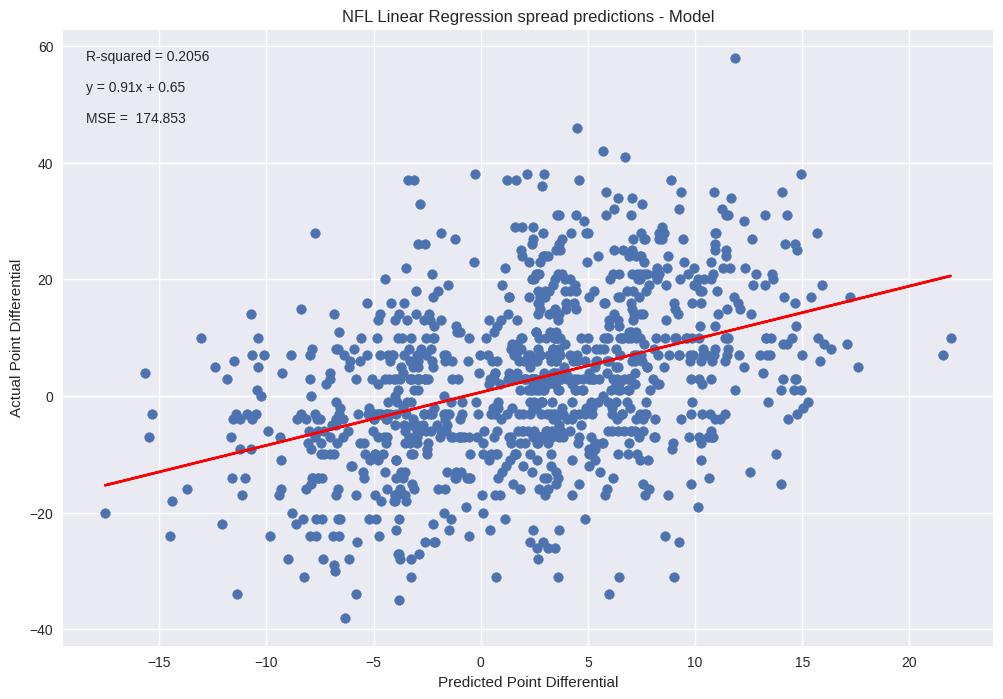

In [ ]:
linR_spread_model = linear_regression(df, target="score_diff", feature_list=spread_feature_list,
                                             title="NFL Linear Regression spread predictions - Model",
                                             xlabel="Predicted Point Differential", ylabel="Actual Point Differential")
linR_spread_model

False


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             score_diff   R-squared (uncentered):                   0.204
Model:                            OLS   Adj. R-squared (uncentered):              0.203
Method:                 Least Squares   F-statistic:                              1050.
Date:                Tue, 23 May 2023   Prob (F-statistic):                   2.29e-205
Time:                        20:51:33   Log-Likelihood:                         -16469.
No. Observations:                4108   AIC:                                  3.294e+04
Df Residuals:                    4107   BIC:                                  3.295e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
spread_line     1.0533      0.033     32.408      0.000       0.990       1.117
==============================================================================
Omnibus:                       12.021   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.145
Skew:                           0.058   Prob(JB):                     0.000848
Kurtosis:                       3.263   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

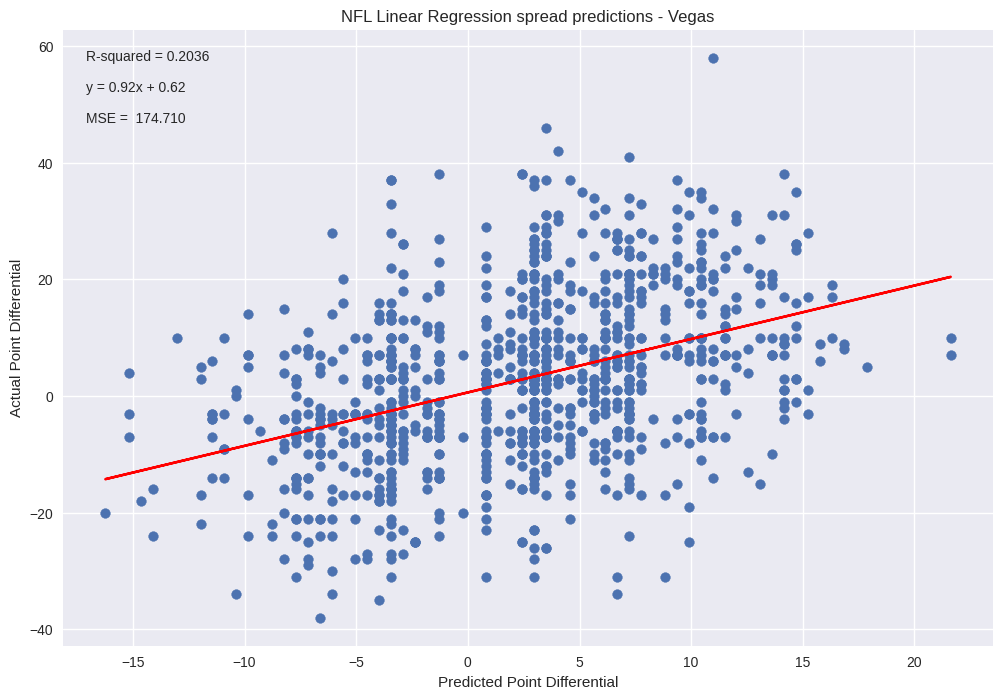

In [ ]:
linR_spread_vegas = linear_regression(df, target="score_diff", feature_list=["spread_line"],
                                             title="NFL Linear Regression spread predictions - Vegas",
                                             xlabel="Predicted Point Differential", ylabel="Actual Point Differential")
linR_spread_vegas

False


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  total   R-squared (uncentered):                   0.916
Model:                            OLS   Adj. R-squared (uncentered):              0.916
Method:                 Least Squares   F-statistic:                              3734.
Date:                Tue, 23 May 2023   Prob (F-statistic):                        0.00
Time:                        20:52:40   Log-Likelihood:                         -16505.
No. Observations:                4108   AIC:                                  3.303e+04
Df Residuals:                    4096   BIC:                                  3.311e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
ewma_dynamic_window_rushing_offense_home    -4.6193      2.699     -1.712      0.087      -9.910       0.671
ewma_dynamic_window_passing_offense_home    -1.9578      1.563     -1.252      0.211      -5.023       1.107
ewma_dynamic_window_rushing_defense_home    -1.1008      2.887     -0.381      0.703      -6.760       4.558
ewma_dynamic_window_passing_defense_home    -3.5328      1.905     -1.855      0.064      -7.267       0.202
ewma_dynamic_window_rushing_offense_away    -0.7626      2.777     -0.275      0.784      -6.208       4.683
ewma_dynamic_window_passing_offense_away     1.5640      1.567      0.998      0.318      -1.508       4.636
ewma_dynamic_window_rushing_defense_away    -5.3963      2.849     -1.894      0.058     -10.981       0.189
ewma_dynamic_window_passing_defense_away    -0.2371      1.864     -0.127      0.899      -3.891       3.417
rest differential                            0.0062      0.085      0.072      0.942      -0.161       0.173
windy                                       -2.5499      0.868     -2.937      0.003      -4.252      -0.848
div_game                                    -0.9713      0.433     -2.242      0.025      -1.821      -0.122
total_line                                   1.0079      0.011     88.462      0.000       0.986       1.030
==============================================================================
Omnibus:                       87.886   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.533
Skew:                           0.345   Prob(JB):                     2.97e-21
Kurtosis:                       3.278   Cond. No.                         630.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

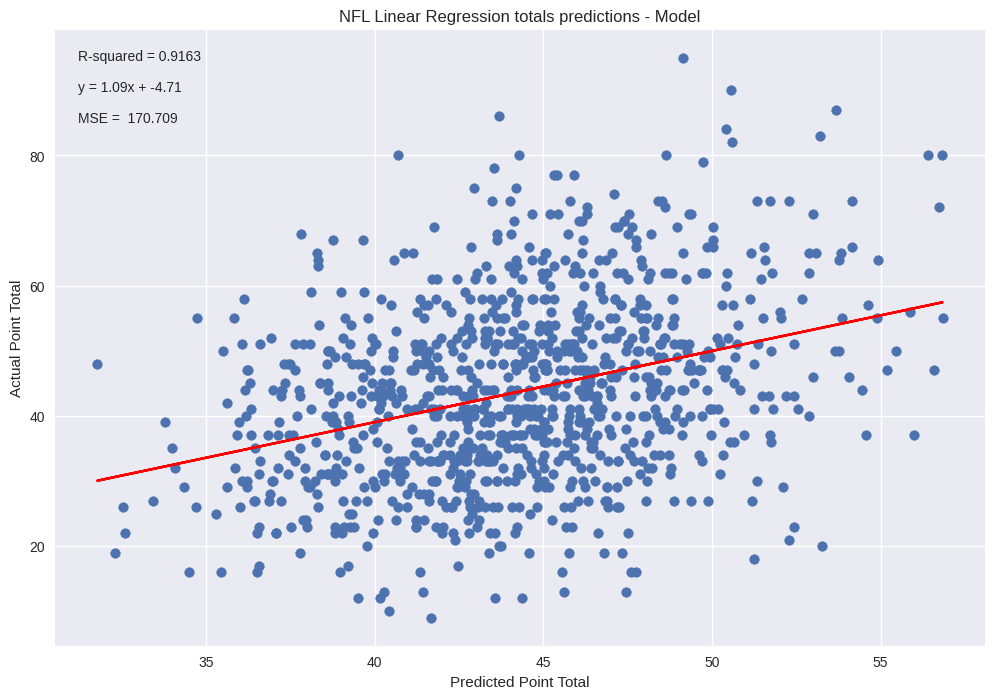

In [ ]:
linR_total_model = linear_regression(df, target="total", feature_list=total_feature_list,
                                             title="NFL Linear Regression totals predictions - Model",
                                             xlabel="Predicted Point Total", ylabel="Actual Point Total")
linR_total_model

False


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  total   R-squared (uncentered):                   0.916
Model:                            OLS   Adj. R-squared (uncentered):              0.916
Method:                 Least Squares   F-statistic:                          4.460e+04
Date:                Tue, 23 May 2023   Prob (F-statistic):                        0.00
Time:                        20:52:44   Log-Likelihood:                         -16519.
No. Observations:                4108   AIC:                                  3.304e+04
Df Residuals:                    4107   BIC:                                  3.305e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
total_line     1.0144      0.005    211.182      0.000       1.005       1.024
==============================================================================
Omnibus:                       86.702   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.330
Skew:                           0.341   Prob(JB):                     5.42e-21
Kurtosis:                       3.283   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

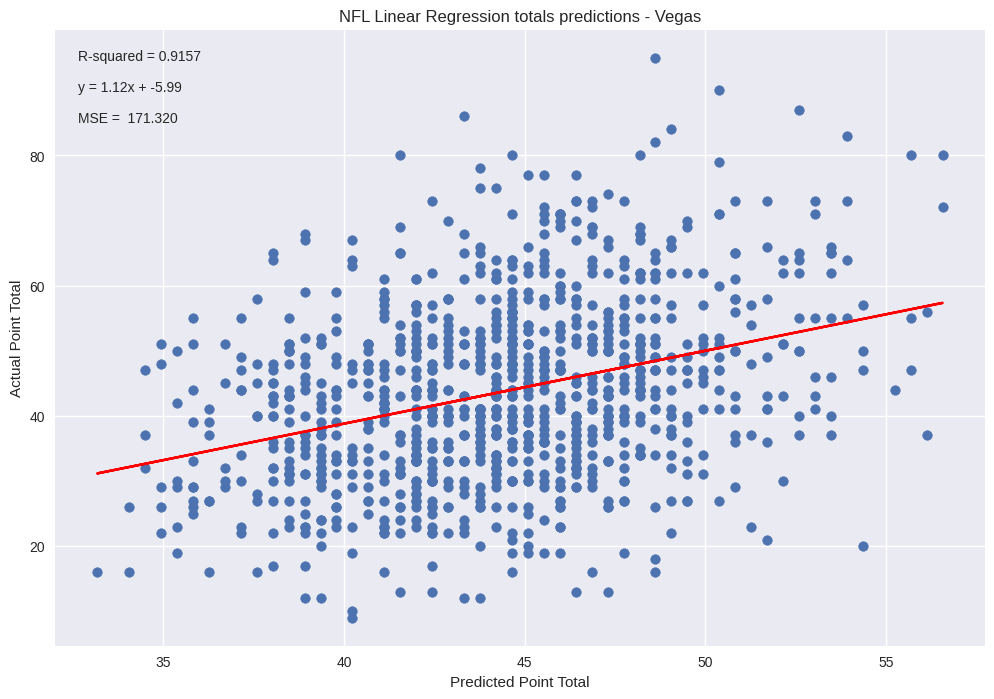

In [ ]:
linR_total_vegas = linear_regression(df, target="total", feature_list=['total_line'],
                                             title="NFL Linear Regression totals predictions - Vegas",
                                             xlabel="Predicted Point Total", ylabel="Actual Point Total")
linR_total_vegas

Optimization terminated successfully.
         Current function value: 0.634948
         Iterations 5


(<class 'statsmodels.iolib.summary.Summary'>
 """
                            Logit Regression Results                           
 Dep. Variable:          home_team_win   No. Observations:                 4108
 Model:                          Logit   Df Residuals:                     4099
 Method:                           MLE   Df Model:                            8
 Date:                Tue, 23 May 2023   Pseudo R-squ.:                 0.07237
 Time:                        20:12:07   Log-Likelihood:                -2608.4
 converged:                       True   LL-Null:                       -2811.9
 Covariance Type:            nonrobust   LLR p-value:                 6.031e-83
                                                coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------------------------------------
 ewma_dynamic_window_rushing_offense_home     1.2418      0.399      3.115      0.002     

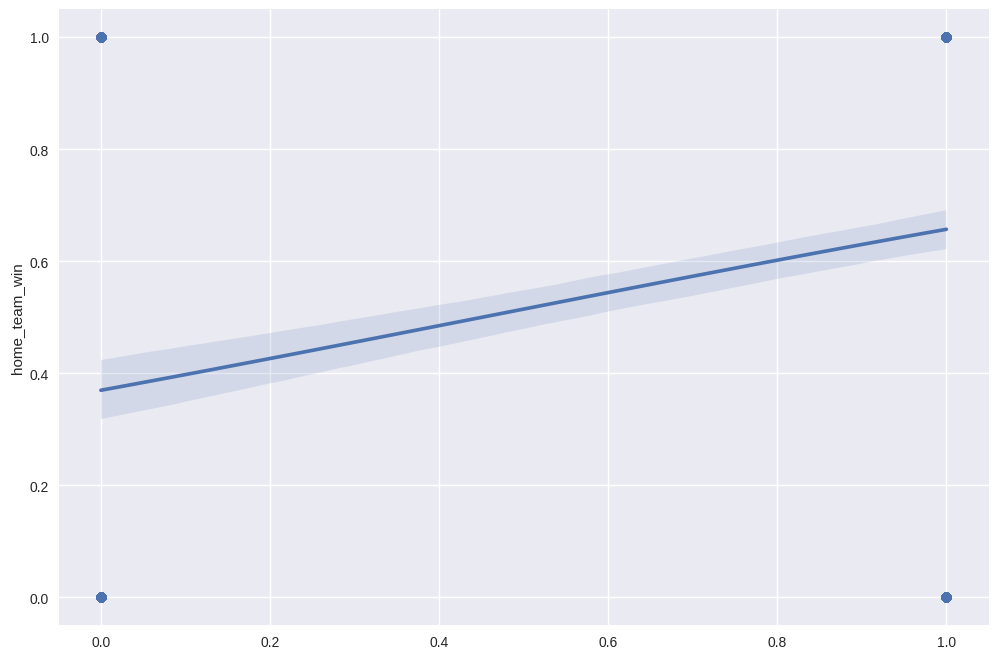

In [ ]:
logR_spread_model = logistic_regression(df, target="home_team_win", feature_list=spread_feature_list,
                                             title="NFL Logistic Regression spread predictions - Model",
                                             xlabel="Predicted Winner", ylabel="Actual Winner")
logR_spread_model